In [2]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Let us read the train and test files and store it.

In [3]:
data_path = "../data/"
train_file = data_path + "train.json"
test_file = data_path + "test.json"
train_df = pd.read_json(train_file)
test_df = pd.read_json(test_file)
print(train_df.shape)
print(test_df.shape)

(49352, 15)
(74659, 14)


We do not need any pre-processing for numerical features and so create a list with those features.

In [4]:
features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

Now let us create some new features from the given features.

In [5]:
# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])

# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour

# adding all these new features to use list #
features_to_use.extend(["num_photos", "num_features", "num_description_words","created_year", "created_month", "created_day", "listing_id", "created_hour"])

We have 4 categorical features in our data

 - display_address
 - manager_id
 - building_id
 - listing_id

So let us label encode these features.

In [6]:
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

We have features column which is a list of string values. So we can first combine all the strings together to get a single string and then apply count vectorizer on top of it.

In [7]:
train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
print(train_df["features"].head())
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

10                                                         
10000     Doorman Elevator Fitness_Center Cats_Allowed D...
100004    Laundry_In_Building Dishwasher Hardwood_Floors...
100007                               Hardwood_Floors No_Fee
100013                                              Pre-War
Name: features, dtype: object


In [8]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

((49352, 217), (74659, 217))


## Example

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

In [9]:
#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

In [11]:
alpha = 0.95

clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)

In [12]:
clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)

In [13]:
X.shape
y.shape

(100,)

In [14]:
clfls = GradientBoostingRegressor(loss='ls',
                                n_estimators=250, max_depth=3,
                                learning_rate=0.1, min_samples_leaf=9,
                                min_samples_split=9)
clfls.fit(X, y)
# Make the prediction on the meshed x-axis
y_pred = clfls.predict(xx)

In [18]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()

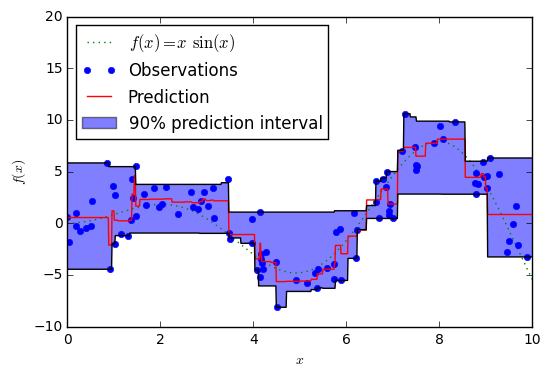

In [19]:
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

## Try:  Plot price by continuous var -- e.g. latitude?

In [10]:
sample_df = train_df.sample(frac=0.1)
sample_df['log_price'] = np.log(sample_df['price'] + 1.0)
sample_df['latitude'].head()
sample_df['price'].head()
sample_df = sample_df[sample_df['latitude'] >= 40.55]
sample_df = sample_df[sample_df['latitude'] <= 40.95]

In [21]:
x = sample_df['latitude'].values.reshape(-1, 1)
y = sample_df['price'].values
y_log = sample_df['log_price'].values


In [12]:
# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
all_x = np.atleast_2d(np.linspace(40.55, 40.95, 1000)).T
all_x = all_x.astype(np.float32)

In [13]:
all_x.shape

(1000, 1)

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
alpha = 0.95
def run(alpha, x, y):
    clf = GradientBoostingRegressor(loss='quantile', alpha=alpha,
                                    n_estimators=250, max_depth=3,
                                    learning_rate=.1, min_samples_leaf=5,
                                    min_samples_split=5)

    clf.fit(x, y)

    # Make the prediction on the meshed x-axis
    y_upper = clf.predict(all_x)

    clf.set_params(alpha=1.0 - alpha)
    clf.fit(x, y)

    # Make the prediction on the meshed x-axis
    y_lower = clf.predict(all_x)
    
    return y_upper, y_lower

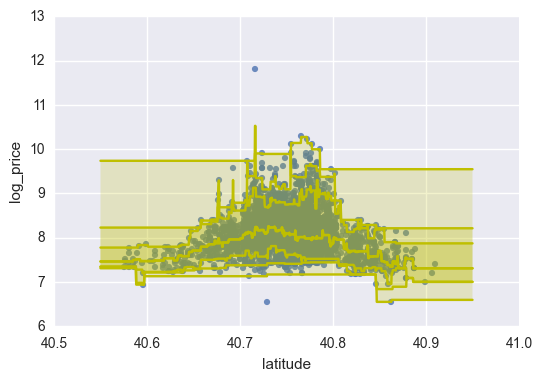

In [23]:
fig = plt.figure()
sns.regplot(x="latitude", y="log_price", fit_reg=False, data=sample_df)

for alpha in [0.999, 0.99, 0.95, 0.50]:
    y_upper, y_lower = run(alpha, x, y_log)
    plt.plot(all_x, y_upper, 'y-')
    plt.plot(all_x, y_lower, 'y-')
    plt.fill(np.concatenate([all_x, all_x[::-1]]),
             np.concatenate([y_upper, y_lower[::-1]]),
             alpha=.2, fc='y', ec='None')

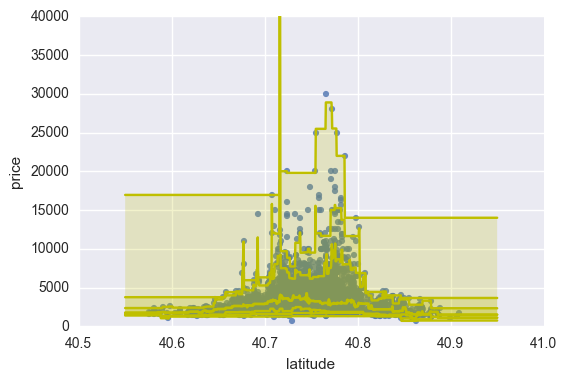

In [26]:
fig = plt.figure()
sns.regplot(x="latitude", y="price", fit_reg=False, data=sample_df)

for alpha in [0.999, 0.99, 0.95, 0.50]:
    y_upper, y_lower = run(alpha, x, y)
    plt.plot(all_x, y_upper, 'y-')
    plt.plot(all_x, y_lower, 'y-')
    plt.fill(np.concatenate([all_x, all_x[::-1]]),
             np.concatenate([y_upper, y_lower[::-1]]),
             alpha=.2, fc='y', ec='None')
    plt.ylim([-10,40000])

In [92]:
?sns.regplot

In [167]:
np.zeros(3,1).size

TypeError: data type not understood